# Plots: heatmaps

In [14]:
import sys
sys.path.append("..\\source\\")
import utils as utils
import glob

# Data and numbers
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
mpl.style.use('default')
mpl.rcParams['axes.linewidth'] = 0.5
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

# Palettes
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set2_8

In [2]:
path_data = "..\\data\\processed\\summary\\"
path_meta = "..\\data\\original\\metadata\\"
path_res = "..\\results\\by_bdg\\"
path_fig = "..\\figures\\"

In [3]:
meters_name = {"electricity": "electricity",
                "chilledwater":"chilled water",
                "hotwater": "hot water",
                "steam": "steam"}

In [4]:
ref = {0:"Good fit", 
1:"A1", 
2:"A2", 
3:"A3", 
4:"A4", 
5:"B1",
6:"B2",
7:"B3",
8:"B4",
9:"C1",
10:"C2",
11:"C3",
12:"C4",
13:"D1",
14:"D2",
15:"D3",
16:"D4",
17:"Undefined"}

In [5]:
#color blind
color_ref = {0:"silver",
1:plt.cm.tab20(6), # red
2:plt.cm.tab20(7), #light red
3:plt.cm.tab20(2), # orange
4:plt.cm.tab20(3), # light orange
5:plt.cm.tab20(4), # green
6:plt.cm.tab20(5), # light green
7:plt.cm.tab20(16), # yellow
8:plt.cm.tab20(17), # light yellow
9:plt.cm.tab20(0), # blue
10:plt.cm.tab20(1), # light blue
11:plt.cm.tab20(18), # cyan
12:plt.cm.tab20(19), # light cyan?
13:plt.cm.tab20(8),  # violet
14:plt.cm.tab20(9), # light violet
15:plt.cm.tab20(12), # pink
16:plt.cm.tab20(13), # light pink
17:"white"}

In [6]:
cmap = [color_ref[0],
color_ref[1], 
color_ref[2],
color_ref[3],
color_ref[4], 
color_ref[5], 
color_ref[6], 
color_ref[7], 
color_ref[8],
color_ref[9], 
color_ref[10],
color_ref[11],
color_ref[12],
color_ref[13], 
color_ref[14],
color_ref[15],
color_ref[16],
color_ref[17]]

# Functions

In [7]:
def get_sites(path_data, path_meta, meter):
    # Load original data
    df = pd.read_pickle(path_data + f"{meter}_RMSLE.pickle.gz")
    # Merge with metadata
    meta_bdg = pd.read_csv(path_meta + "building_metadata.csv")
    df = pd.merge(df, meta_bdg, how="left", on="building_id")
    # List of buildings and sites
    bdgs = list(df.building_id.unique())
    sites = list(df.site_id.unique())
    print(f"sites: {len(sites)}. Buildings: {len(bdgs)}")

    return sites

In [8]:
def error_df(path_error, meter, error, site):

    error0 = pd.read_csv(path_res + f"{meter}_Z_site{site}.csv")
    df_error = error0.copy()
    df_error = df_error.replace(1,0)

    error2 = pd.read_csv(path_res + f"{meter}_{error}2_site{site}.csv")
    df_error.update(error2)
    df_error = df_error.replace(1,2)

    error3 = pd.read_csv(path_res + f"{meter}_{error}3_site{site}.csv")
    df_error.update(error3)
    df_error = df_error.replace(1,3)

    error4 = pd.read_csv(path_res + f"{meter}_{error}4_site{site}.csv")
    df_error.update(error4)
    df_error = df_error.replace(1,4)

    error1 = pd.read_csv(path_res + f"{meter}_{error}1_site{site}.csv")
    df_error.update(error1)
  

    #df_error = df_error.fillna(0)

    df_error = df_error.apply(pd.to_numeric, errors='coerce')
    df_error.set_index("building_id",inplace=True)
    print(f"Site {site} error's dataframe created.")
    errors_type = df_error.melt().value.unique()
    
    return df_error, errors_type

In [9]:
def choose_palette(errors_type, ref):

    #cmap = Set2_8.mpl_colors # callable
    #cmap = [cmap[7],cmap[6],cmap[4],cmap[3],cmap[1],cmap[2],cmap[0],"white"]#,cmap[5]]
    cmap = ["silver","firebrick", "salmon", "darkorange", "sandybrown", "royalblue", "darkorchid", "darkgreen","limegreen", "yellowgreen","palegreen","white"]

    pal = []
    names = []

    for i in sorted(errors_type):
        # color list
        color = cmap[int(i)]
        pal.append(color)
        # name list
        name = ref[i]
        names.append(name)

    #cmap1 = pal[1:]
    #names1 = names[1:]

    return pal, names

In [10]:
def setSize(rows):
    if rows == 1:
        size = (5,5)
    elif rows == 2:
        size = (5,10)
    elif rows == 3:
        size = (5,15)
    else:
        size = (5,20)
    
    return size

In [11]:
def error_df_all(path_error, meter, site):

    # Good fit
    error0 = pd.read_csv(path_res + f"{meter}_Z_site{site}.csv")
    df_error = error0.copy()
    df_error = df_error.replace(1,0)

    # In range single bdg
    error1 = pd.read_csv(path_res + f"{meter}_A1_site{site}.csv")
    df_error.update(error1)
    df_error = df_error.replace(1,99)

    error2 = pd.read_csv(path_res + f"{meter}_A2_site{site}.csv")
    df_error.update(error2)
    df_error = df_error.replace(1,2)

    error3 = pd.read_csv(path_res + f"{meter}_A3_site{site}.csv")
    df_error.update(error3)
    df_error = df_error.replace(1,3)

    error4 = pd.read_csv(path_res + f"{meter}_A4_site{site}.csv")
    df_error.update(error4)
    df_error = df_error.replace(1,4)

    # in range multiple bdg
    error9 = pd.read_csv(path_res + f"{meter}_C1_site{site}.csv")
    df_error.update(error9)
    df_error = df_error.replace(1,9)

    error10 = pd.read_csv(path_res + f"{meter}_C2_site{site}.csv")
    df_error.update(error10)
    df_error = df_error.replace(1,10)

    error11 = pd.read_csv(path_res + f"{meter}_C3_site{site}.csv")
    df_error.update(error11)
    df_error = df_error.replace(1,11)

    error12 = pd.read_csv(path_res + f"{meter}_C4_site{site}.csv")
    df_error.update(error12)
    df_error = df_error.replace(1,12)

    # Out of range single bdg
    error5 = pd.read_csv(path_res + f"{meter}_B1_site{site}.csv")
    df_error.update(error5)
    df_error = df_error.replace(1,5)

    error6 = pd.read_csv(path_res + f"{meter}_B2_site{site}.csv")
    df_error.update(error6)
    df_error = df_error.replace(1,6)

    error7 = pd.read_csv(path_res + f"{meter}_B3_site{site}.csv")
    df_error.update(error7)
    df_error = df_error.replace(1,7)

    error8 = pd.read_csv(path_res + f"{meter}_B4_site{site}.csv")
    df_error.update(error8)
    df_error = df_error.replace(1,8)

    # Out of range multiple bdg
    error13 = pd.read_csv(path_res + f"{meter}_D1_site{site}.csv")
    df_error.update(error13)
    df_error = df_error.replace(1,13)

    error14 = pd.read_csv(path_res + f"{meter}_D2_site{site}.csv")
    df_error.update(error14)
    df_error = df_error.replace(1,14)

    error15 = pd.read_csv(path_res + f"{meter}_D3_site{site}.csv")
    df_error.update(error15)
    df_error = df_error.replace(1,15)

    error16 = pd.read_csv(path_res + f"{meter}_D4_site{site}.csv")
    df_error.update(error16)
    df_error = df_error.replace(1,16)

    df_error = df_error.replace(99,1)

    # Undefined
    df_error = df_error.fillna(17)

    df_error = df_error.apply(pd.to_numeric, errors='coerce')
    df_error.set_index("building_id",inplace=True)
    print(f"Site {site} error's dataframe created.")
    errors_type = df_error.melt().value.unique()
    
    return df_error, errors_type

# Plots by meter


Meter electricity
Site 0 not available for electricity.
Site 1 not available for electricity.
Site 2 not available for electricity.
Site 3 error's dataframe created.
Site 4 error's dataframe created.
Site 5 error's dataframe created.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 error's dataframe created.
Site 9 error's dataframe created.
Site 10 error's dataframe created.
Site 11 error's dataframe created.
Site 12 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Site 15 not available for electricity.

Meter chilledwater
Site 0 not available for chilledwater.
Site 1 not available for chilledwater.
Site 2 not available for chilledwater.
Site 3 not available for chilledwater.
Site 4 not available for chilledwater.
Site 5 not available for chilledwater.
Site 6 error's dataframe created.
Site 7 error's dataframe created.
Site 8 not available for chilledwater.
Site 9 error's dataframe created.
Site 10 error's data

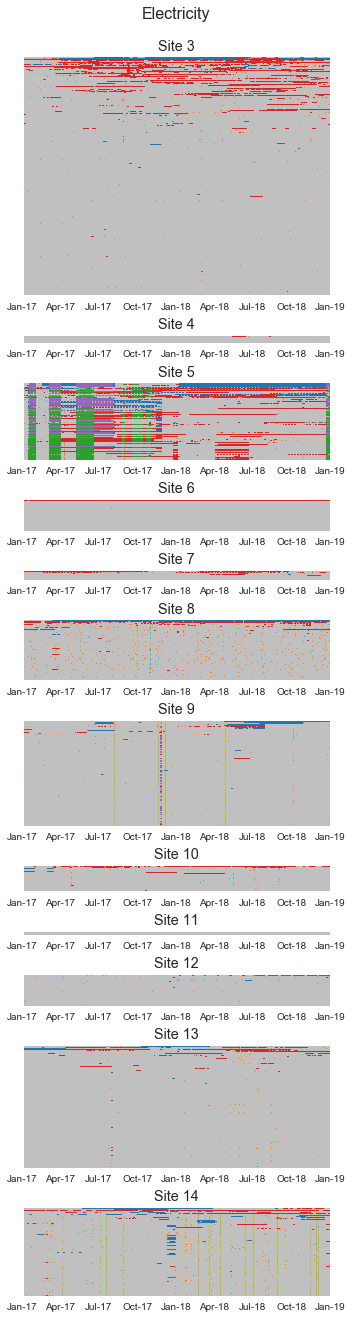

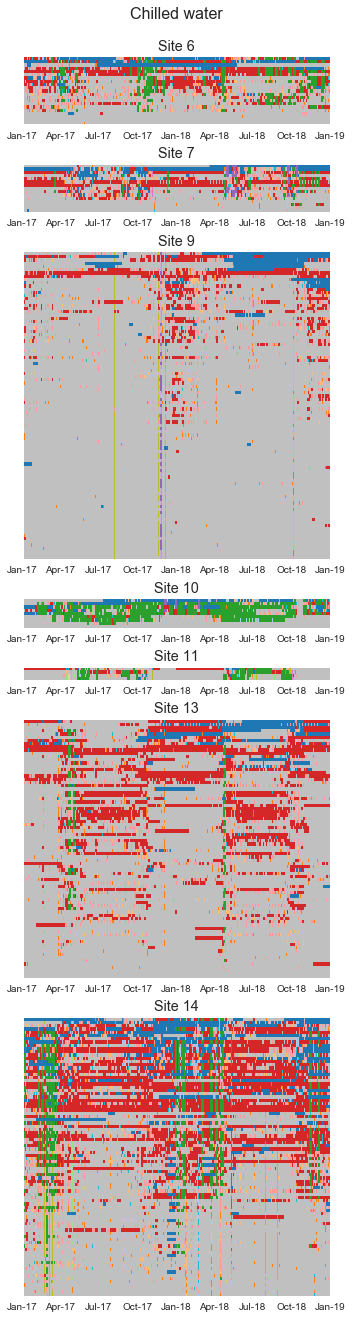

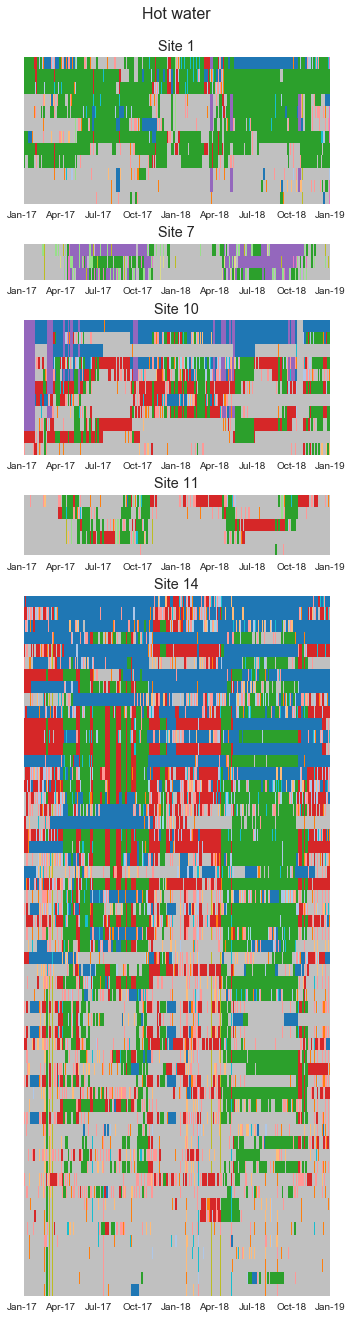

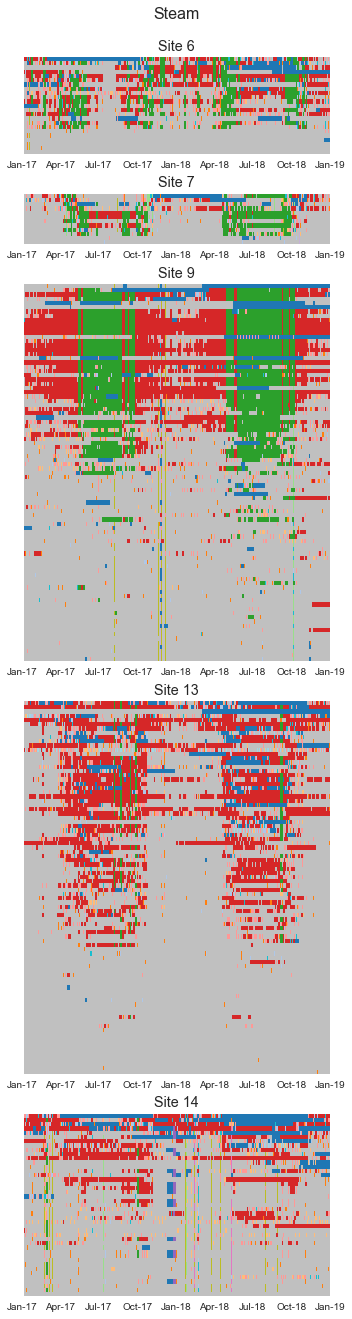

In [14]:
meters = ["electricity","chilledwater","hotwater","steam"]
#meters = ["chilledwater"]
sites = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#error_name = "B"

for meter in meters:
    print(f"\nMeter {meter}")

    df_list = []
    errors_list = []
    sites_list = []

    for site in sites:

        try:
            df_error, error_types = error_df_all(path_res, meter, site)
            df_list.append(df_error)
            errors_list.append(error_types)
            sites_list.append(site)

        except:
            print(f"Site {site} not available for {meter}.")

    # Remove sites with only one building
    df_list_filter = []
    sites_list_filter = []
    errors_list_filter = []

    for df,site,error in zip(df_list,sites_list,errors_list):
        if (len(df) > 1):
            df_list_filter.append(df)
            sites_list_filter.append(site)
            errors_list_filter.append(error)

    cols = 1 #2
    rows = len(df_list_filter)

    # Ratios to make height of subplot dependant of number of buldings
    ratios = [len(df) for df in df_list_filter]

    # Size of figure dependant on number of plots
    figsize = setSize(rows)

    fig, axes = plt.subplots(rows, cols, sharex = False, sharey=False, figsize=figsize, gridspec_kw = {"height_ratios": ratios})#, "width_ratios": [4,1]})
    plots = rows * cols
    axes = axes.flatten() if plots > 1 else axes

    i = 0
    for df,error,site in zip(df_list_filter, errors_list_filter, sites_list_filter):

        # Color palettes
        errors = sorted(error)
        #cmap0 = ListedColormap(cmap)
        #cmap1, names1 = choose_palette(error,ref)

        ## HEATMAP
        # Get the data
        y = np.linspace(0, len(df), len(df)+1)
        x = pd.date_range(start='2017-01-01', end='2019-01-01')
        data = df
        cmap_new = ListedColormap(cmap)
        # Plot
        ax0 = axes[i] if plots>1 else axes
        qmesh = ax0.pcolormesh(x, y, data, cmap=cmap_new, rasterized=True, vmin=0, vmax=17)
        # Axis
        plt.locator_params(axis='y', nbins=len(list(data.index))+1)
        ax0.set_title(f"Site {site}")
        ax0.axis('tight') 
        ax0.xaxis_date() # Set up as dates
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        ax0.set_yticklabels("") # omit building ID on y axis

        i = i+1    

    # Figure parameters
    fig.suptitle(f"{meters_name[meter].capitalize()}", y = 1.015, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    #fig.savefig(path_fig + f"{meter}_allErrrors.pdf", dpi=150, bbox_inches="tight")
    #fig.savefig(path_fig + f"{meter}_allErrrors.png", dpi=150, bbox_inches="tight")

# Plots by selected sites

In [12]:
def sites_to_plot(meter):

    if (meter == "chilledwater") or (meter == "steam"):
        sites = [9,13,14]
    elif meter == "electricity":
        sites = [5,9,14]
    elif meter == "hotwater":
        sites = [1,10,14]
    
    return sites

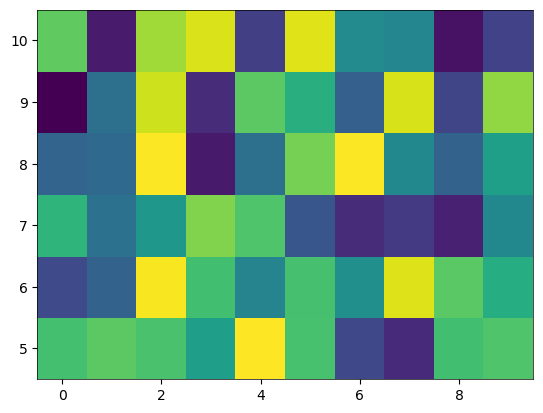

In [19]:
mpl.style.use('default')
mpl.rcParams['axes.linewidth'] = 0.5

np.random.seed(19680801)
Z = np.random.rand(6, 10)
x = np.arange(-0.5, 10, 1)  # len = 11
y = np.arange(4.5, 11, 1)  # len = 7

fig, ax = plt.subplots()
ax.pcolormesh(x, y, Z)


Meter electricity
Site 5 error's dataframe created.
Site 9 error's dataframe created.
Site 14 error's dataframe created.
Total bdgs: 313. Ratios: [0.59, 0.81, 0.68]. Fig height: 11.69

Meter chilledwater
Site 9 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Total bdgs: 261. Ratios: [0.63, 0.53, 0.57]. Fig height: 9.74

Meter hotwater
Site 1 error's dataframe created.
Site 10 error's dataframe created.
Site 14 error's dataframe created.
Total bdgs: 80. Ratios: [0.08, 0.07, 0.38]. Fig height: 2.99

Meter steam


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


Site 9 error's dataframe created.
Site 13 error's dataframe created.
Site 14 error's dataframe created.
Total bdgs: 220. Ratios: [0.59, 0.59, 0.29]. Fig height: 8.21


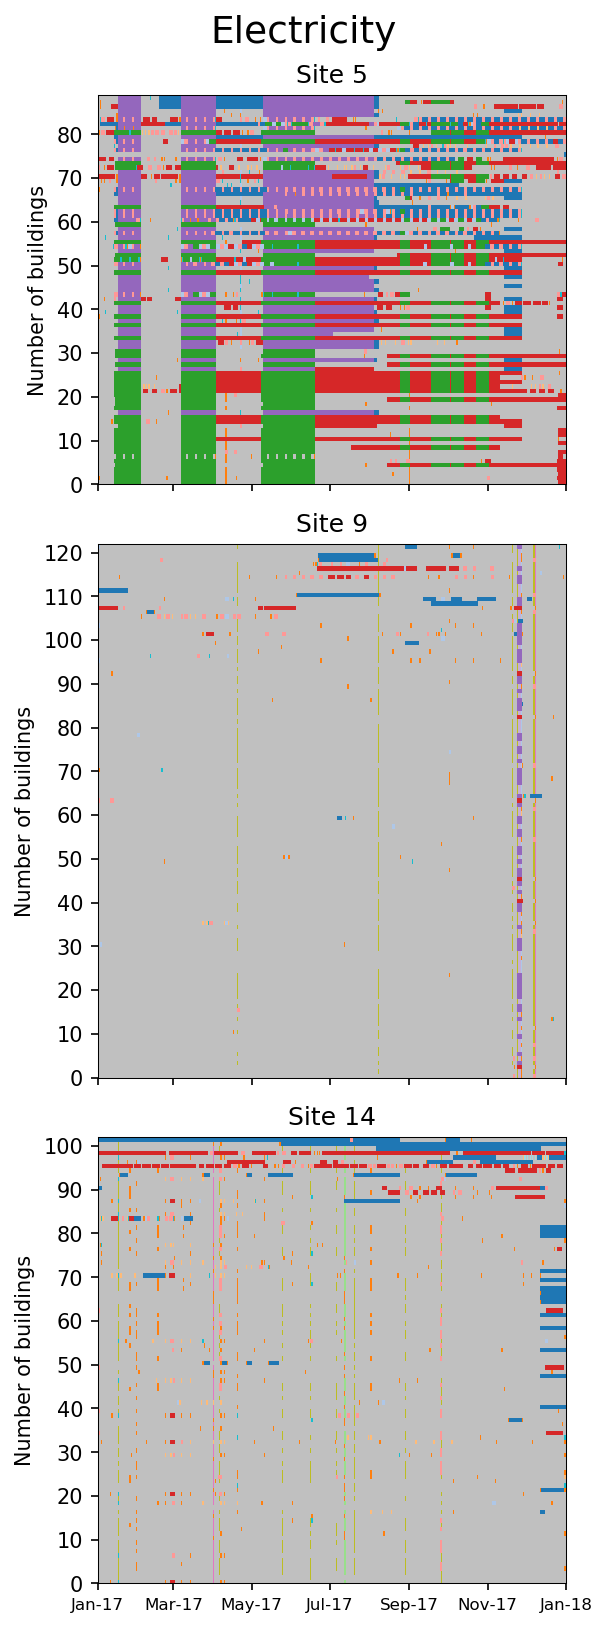

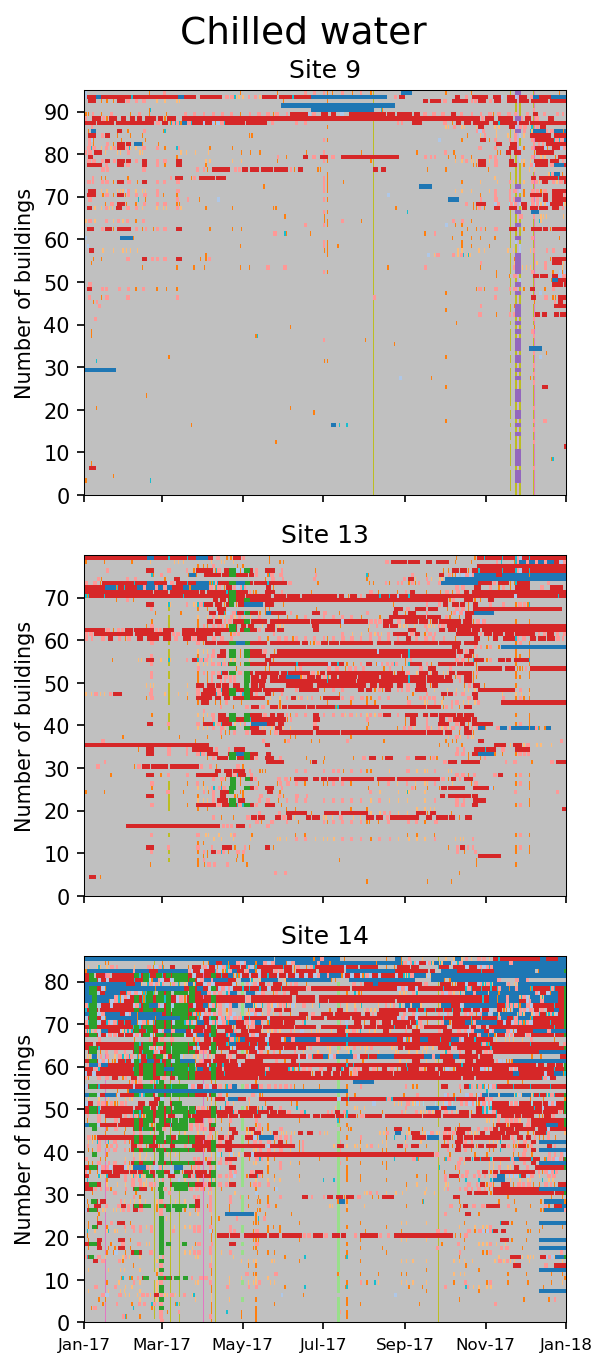

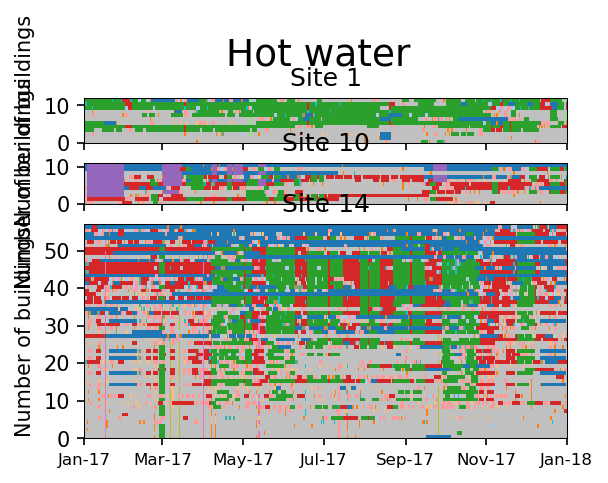

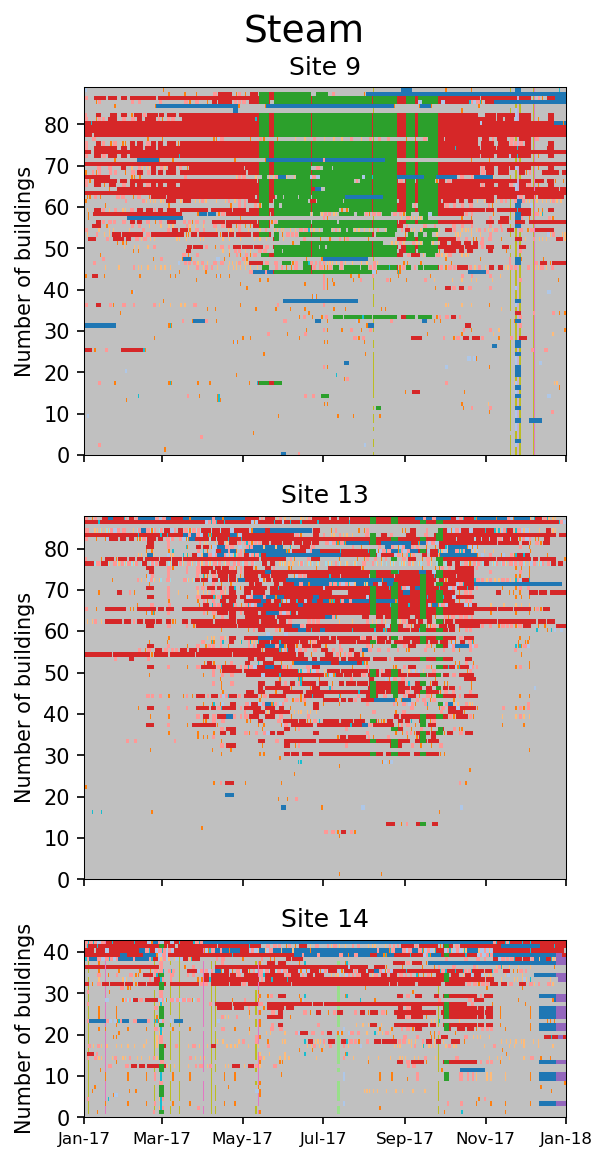

In [44]:
meters = ["electricity","chilledwater","hotwater","steam"]
#meters = ["steam"]

for meter in meters:
    print(f"\nMeter {meter}")

    df_list = []
    errors_list = []
    sites_list = []

    sites = sites_to_plot(meter)
    for site in sites:

        try:
            df_error, error_types = error_df_all(path_res, meter, site)
            df_list.append(df_error)
            errors_list.append(error_types)
            sites_list.append(site)

        except:
            print(f"Site {site} not available for {meter}.")

    # Remove sites with only one building
    df_list_filter = []
    errors_list_filter = []

    for df,site,error in zip(df_list,sites_list,errors_list):
        if (len(df) > 1):
            df_list_filter.append(df)
            errors_list_filter.append(error)

    cols = 1 #2
    rows = len(df_list_filter)
    dpi = 150
    squaresize = 5.6
    ratios = [len(df)/dpi for df in df_list_filter]

    total_bdgs = 0
    for j in df_list_filter:
        total_bdgs = total_bdgs + len(j)

    figheight = total_bdgs*squaresize/float(dpi) # max 11.7 inches
    print(f"Total bdgs: {total_bdgs}. Ratios: {[round(r,2) for r in ratios]}. Fig height: {round(figheight,2)}")

    # Ratios to make height of subplot dependant of number of buldings
    #ratios = [len(df) for df in df_list_filter]

    # Size of figure dependant on number of plots
    #figsize = setSize(rows)

    fig, axes = plt.subplots(rows, cols, sharex = True, sharey=False, figsize=(4.15,figheight), dpi=dpi, gridspec_kw = {"height_ratios": ratios})#, "width_ratios": [4,1]})
    plots = rows * cols
    axes = axes.flatten() if plots > 1 else axes

    i = 0
    for df,error,site in zip(df_list_filter, errors_list_filter, sites):

        # Color palettes
        errors = sorted(error)
        #cmap0 = ListedColormap(cmap)
        #cmap1, names1 = choose_palette(error,ref)

        ## HEATMAP
        # Get the data
        y = np.linspace(0, len(df), len(df)+1)
        x = pd.date_range(start='2017-01-01', end='2019-01-01')
        cmap_new = ListedColormap(cmap)
        data = df
        # Plot
        ax0 = axes[i] if plots>1 else axes
        qmesh = ax0.pcolormesh(x, y, data, cmap=cmap_new, rasterized=True, vmin=0, vmax=17)
        # Axis
        '''plt.locator_params(axis='y', nbins=len(list(data.index))+1)
        ax0.set_title(f"Site {site}", fontsize=12)
        ax0.axis('tight') 
        ax0.xaxis_date() # Set up as dates
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        #ax0.set_ylabel("Number of buildings")
        ax0.set_xlabel("")
        ax0.set_yticklabels("") # omit building ID on y axis
        ax0.set_xlim([dt.date(2017, 1, 1), dt.date(2018, 1, 1)])
        plt.xticks(rotation=0, fontsize=6)'''
        
        ax0.set_title(f"Site {site}", fontsize=12)
        ax0.axis('tight') 
        ax0.xaxis_date() # Set up as dates
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        ax0.set_xlim([dt.date(2017, 1, 1), dt.date(2018, 1, 1)])
        #ax0.set_xlabel("Date")
        plt.xticks(rotation=0, fontsize=8)

        ax0.set_yticks(np.arange(0,len(df),10))
        ax0.set_ylabel("Number of buildings")

        i = i+1    

    # Figure parameters
    fig.suptitle(f"{meters_name[meter].capitalize()}", y = 1.015, fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)

    '''if meter == "hotwater":
        cax = plt.axes([0.06, 0, 0.92,  0.1/figheight])

    else:
        cax = plt.axes([0.06, 0.08, 0.92, 0.1/figheight])

    tick_locs = (np.arange(17) + 0.5)*(17-1)/17
    cbar = plt.colorbar(qmesh,orientation='horizontal',ticks=tick_locs, cax=cax, spacing="proportional")
    cbar.set_ticklabels(list(ref.values())[:-1])
    cbar.ax.tick_params(labelsize=6)'''

    #fig.savefig(path_fig + f"{meter}_allErrors_selectedSites.pdf", dpi=150, bbox_inches="tight")
    #fig.savefig(path_fig + f"{meter}_allErrors_selectedSites.png", dpi=150, bbox_inches="tight")

# Reference bar

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

In [13]:
colors = [color_ref[0],
color_ref[1], 
color_ref[2],
color_ref[3],
color_ref[4], 
color_ref[5], 
color_ref[6], 
color_ref[7], 
color_ref[8],
color_ref[9], 
color_ref[10],
color_ref[11],
color_ref[12],
color_ref[13], 
color_ref[14],
color_ref[15],
color_ref[16]]

ref1 = {0:"Good fit"}
ref2 = {1:"A1", 
        2:"A2", 
        3:"A3", 
        4:"A4", 
        5:"B1",
        6:"B2",
        7:"B3",
        8:"B4"}
ref3 =  {9:"C1",
        10:"C2",
        11:"C3",
        12:"C4",
        13:"D1",
        14:"D2",
        15:"D3",
        16:"D4"}

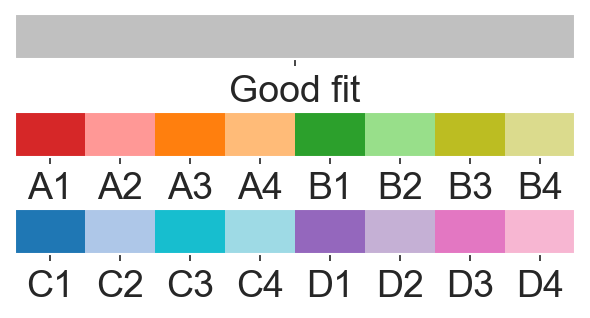

In [14]:
fig = plt.figure(figsize=(4.15, 2), dpi=150)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax2 = fig.add_axes([0.05, 0.475, 0.9, 0.15])
ax3 = fig.add_axes([0.05, 0.15, 0.9, 0.15])

tick_locs = ((np.arange(8) + 0.5)*(8-1)/8) + 1

###########################################################
cmap1 = ListedColormap(colors[0])
tick_labels1 = list(ref1.values())
norm1 = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax1, 
                                cmap=cmap1,
                                ticks=[0.5],
                                norm=norm1,
                                orientation='horizontal')
cb1.set_ticklabels(tick_labels1)
cb1.ax.tick_params(labelsize=18)
###########################################################
cmap2 = ListedColormap(colors[1:9])
tick_labels2 = list(ref2.values())
norm2 = mpl.colors.Normalize(vmin=1, vmax=8)
cb2 = mpl.colorbar.ColorbarBase(ax2, 
                                cmap=cmap2,
                                ticks=tick_locs,
                                norm=norm2,
                                orientation='horizontal')
cb2.set_ticklabels(tick_labels2)
cb2.ax.tick_params(labelsize=18)
###########################################################
cmap3 = ListedColormap(colors[9:])
tick_labels3 = list(ref3.values())
norm3 = mpl.colors.Normalize(vmin=1, vmax=8)
cb3 = mpl.colorbar.ColorbarBase(ax3, 
                                cmap=cmap3,
                                ticks=tick_locs,
                                norm=norm3,
                                orientation='horizontal')
cb3.set_ticklabels(tick_labels3)
cb3.ax.tick_params(labelsize=18)
###########################################################
plt.show()

fig.savefig(path_fig + f"colorbar_all.pdf", dpi=150, bbox_inches="tight")